## Sensitivity to perturbations
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/sensitivity_to_perturbation.html

### Steps
1. resetting the network
1. resetting the random network generator
1. resetting the internal clock
1. deleting all entries in the spike recorder
1. introducing a hyperpolarization phase between the trials (in order to avoid that spikes remaining in the NEST memory after the first simulation are fed into the second simulation)

In [81]:
import matplotlib.pyplot as plt
import nest
import numpy

In [82]:
# We start with the global network parameters.


NE = 1000  # number of excitatory neurons
NI = 250  # number of inhibitory neurons
N = NE + NI  # total number of neurons
KE = 100  # excitatory in-degree
KI = 25  # inhibitory in-degree

In [83]:
neuron_model = "iaf_psc_delta"
neuron_params = nest.GetDefaults(neuron_model)
Vmin = neuron_params["E_L"]  # minimum of initial potential distribution (mV)
Vmax = neuron_params["V_th"]  # maximum of initial potential distribution (mV)

In [84]:
J = 0.5  # excitatory synaptic weight (mV)
g = 6.0  # relative inhibitory weight
delay = 0.1  # spike transmission delay (ms)


# External input parameters.


Jext = 0.2  # PSP amplitude for external Poisson input (mV)
rate_ext = 5700.0  # rate of the external Poisson input
### for mEPSP?


# Perturbation parameters.


t_stim = 400.0  # perturbation time (time of the extra spike)
Jstim = Jext  # perturbation amplitude (mV)


# Simulation parameters.


T = 1000.0  # simulation time per trial (ms)
fade_out = 2.0 * delay  # fade out time (ms)
dt = 0.01  # simulation time resolution (ms)
seed_NEST = 30  # seed of random number generator in Nest
seed_numpy = 30  # seed of random number generator in NumPy

senders = []
spiketimes = []

In [85]:
# we run the two simulations successively. After each simulation the
# sender ids and spiketimes are stored in a list (``senders``, ``spiketimes``).

for trial in [0, 1]:
    ###############################################################################
    # Before we build the network, we reset the simulation kernel to ensure
    # that previous NEST simulations in the Python shell will not disturb this
    # simulation and set the simulation resolution (later defined
    # synaptic delays cannot be smaller than the simulation resolution).

    nest.ResetKernel()
    nest.local_num_threads = 20
    nest.resolution = dt

    ###############################################################################
    # Now we start building the network and create excitatory and inhibitory nodes
    # and connect them. According to the connectivity specification, each neuron
    # is assigned random KE synapses from the excitatory population and random KI
    # synapses from the inhibitory population.

    nodes_ex = nest.Create(neuron_model, NE)
    nodes_in = nest.Create(neuron_model, NI)
    allnodes = nodes_ex + nodes_in

    nest.Connect(
        nodes_ex, allnodes, conn_spec={"rule": "fixed_indegree", "indegree": KE}, syn_spec={"weight": J, "delay": dt}
    )
    nest.Connect(
        nodes_in,
        allnodes,
        conn_spec={"rule": "fixed_indegree", "indegree": KI},
        syn_spec={"weight": -g * J, "delay": dt},
    )

    ###############################################################################
    # Afterwards we create a ``poisson_generator`` that provides spikes (the external
    # input) to the neurons until time ``T`` is reached.
    # Afterwards a ``dc_generator``, which is also connected to the whole population,
    # provides a strong hyperpolarization step for a short time period ``fade_out``.
    #
    # The ``fade_out`` period has to last at least twice as long as the simulation
    # resolution to suppress the neurons from firing.

    ext = nest.Create("poisson_generator", params={"rate": rate_ext, "stop": T})
    nest.Connect(ext, allnodes, syn_spec={"weight": Jext, "delay": dt})

    suppr = nest.Create("dc_generator", params={"amplitude": -1e16, "start": T, "stop": T + fade_out})
    nest.Connect(suppr, allnodes)

    spikerecorder = nest.Create("spike_recorder")
    nest.Connect(allnodes, spikerecorder)

    ###############################################################################
    # We then create the ``spike_generator``, which provides the extra spike
    # (perturbation).

    stimulus = nest.Create("spike_generator")
    stimulus.spike_times = []

    ###############################################################################
    # We need to reset the random number generator and the clock of
    # the simulation Kernel. In addition, we ensure that there is no spike left in
    # the spike recorder.

    nest.rng_seed = seed_NEST

    spikerecorder.n_events = 0

    # We assign random initial membrane potentials to all neurons

    numpy.random.seed(seed_numpy)
    Vms = Vmin + (Vmax - Vmin) * numpy.random.rand(N)
    allnodes.V_m = Vms

    ##############################################################################
    # In the second trial, we add an extra input spike at time ``t_stim`` to the
    # neuron that fires first after perturbation time ``t_stim``. Thus, we make sure
    # that the perturbation is transmitted to the network before it fades away in
    # the perturbed neuron. (Single IAF-neurons are not chaotic.)

    if trial == 1:
        id_stim = [senders[0][spiketimes[0] > t_stim][0]]
        nest.Connect(stimulus, nest.NodeCollection(id_stim), syn_spec={"weight": Jstim, "delay": dt})
        stimulus.spike_times = [t_stim]

    # Now we simulate the network and add a fade out period to discard
    # remaining spikes.

    nest.Simulate(T)
    nest.Simulate(fade_out)

    # Storing the data.

    senders += [spikerecorder.get("events", "senders")]
    spiketimes += [spikerecorder.get("events", "times")]


Oct 10 08:37:36 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Oct 10 08:37:36 NodeManager::prepare_nodes [Info]: 
    Preparing 1330 nodes for simulation.

Oct 10 08:37:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1330
    Simulation time (ms): 1000
    Number of OpenMP threads: 20
    Number of MPI processes: 1

Oct 10 08:37:37 SimulationManager::run [Info]: 
    Simulation finished.

Oct 10 08:37:37 NodeManager::prepare_nodes [Info]: 
    Preparing 1330 nodes for simulation.

Oct 10 08:37:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1330
    Simulation time (ms): 0.2
    Number of OpenMP threads: 20
    Number of MPI processes: 1

Oct 10 08:37:37 SimulationManager::run [Info]: 
    Simulation finished.

Oct 10 08:37:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Oct 10 08:37:37 NodeManager::prepare_nodes [Info]: 
    Preparing 1330

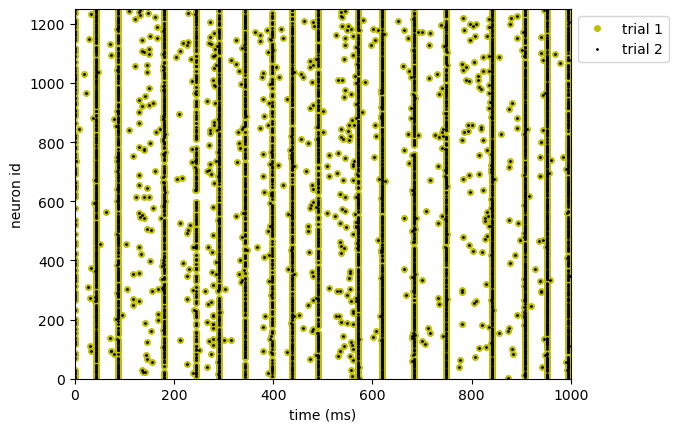

In [86]:
plt.figure(1)
plt.clf()
plt.plot(spiketimes[0], senders[0], "yo", ms=4.0)
plt.plot(spiketimes[1], senders[1], "ko", ms=1.0)
plt.xlabel("time (ms)")
plt.ylabel("neuron id")
plt.xlim((0, T))
plt.ylim((0, N))
plt.legend(["trial 1", "trial 2"], loc="upper left", bbox_to_anchor=(1.0, 1))
plt.show()